# Griffin-Lim algorithm comparison between LibROSA and TF

In [1]:
import glob
import tempfile
import time

import librosa.display
import yaml

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import GridBox, Label, Layout, Audio
from tensorflow_tts.utils import TFGriffinLim, griffin_lim_lb

# %config InlineBackend.figure_format = 'svg'

Get mel spectrogram example and corresponding ground truth audio. We use raw features for this example, if your input is a normalized mel spectrogram you can pass `stats_path` argument for denormalization before generating the audio.

In [11]:
mel_spec = np.load("../dump/train/raw-feats/LJ001-0007-raw-feats.npy")
gt_wav = np.load("../dump/train/wavs/LJ001-0007-wave.npy")

stats_path = "../dump/stats.npy"
dataset_config_path = "../preprocess/ljspeech_preprocess.yaml"
config = yaml.load(open(dataset_config_path), Loader=yaml.Loader)

griffin_lim_tf = TFGriffinLim(dataset_config_path)

TF version has GPU compatibility and supports batch dimension.

In [12]:
inv_wav_tf = griffin_lim_tf(mel_spec[tf.newaxis, :], n_iter=32)  # [1, mel_len] -> [1, audio_len]
inv_wav_lb = griffin_lim_lb(mel_spec, dataset_config_path)  # [mel_len] -> [audio_len]

Time comparison between both implementations.

In [13]:
%timeit griffin_lim_tf(mel_spec[tf.newaxis, :])

46.9 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%timeit griffin_lim_lb(mel_spec, dataset_config_path)

512 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
tf_wav = tf.audio.encode_wav(inv_wav_tf[0, :, tf.newaxis], config["sampling_rate"])
lb_wav = tf.audio.encode_wav(inv_wav_lb[:, tf.newaxis], config["sampling_rate"])
gt_wav_ = tf.audio.encode_wav(gt_wav[:, tf.newaxis], config["sampling_rate"])

In [18]:
items = [
    Audio(value=x.numpy(), autoplay=False, loop=False)
    for x in [gt_wav_, lb_wav, tf_wav]
]
labels = [Label("Ground Truth"), Label("Librosa"), Label("TensorFlow")]
GridBox(
    children=[*labels, *items],
    layout=Layout(grid_template_columns="25% 25% 25%", grid_template_rows="30px 30px"),
)

GridBox(children=(Label(value='Ground Truth'), Label(value='Librosa'), Label(value='TensorFlow'), Audio(value=…

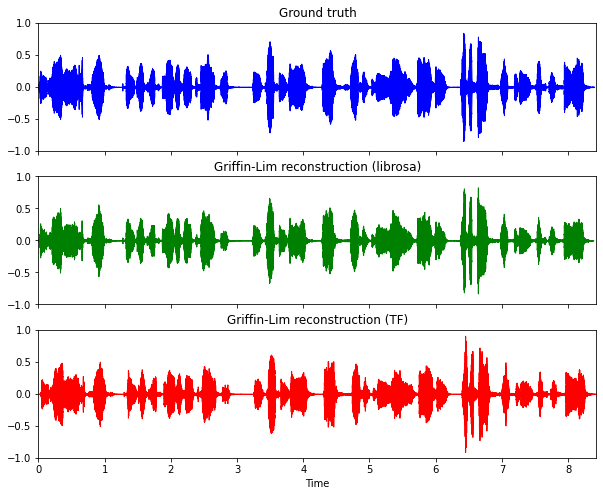

In [19]:
_, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharey=True, sharex=True)
librosa.display.waveplot(gt_wav, sr=config["sampling_rate"], color="b", ax=ax1)
ax1.set_title("Ground truth")
ax1.set_xlabel("")
librosa.display.waveplot(inv_wav_lb, sr=config["sampling_rate"], color="g", ax=ax2)
ax2.set_title("Griffin-Lim reconstruction (librosa)")
ax2.set_xlabel("")
librosa.display.waveplot(
    inv_wav_tf[0].numpy(), sr=config["sampling_rate"], color="r", ax=ax3
)
ax3.set_title("Griffin-Lim reconstruction (TF)")

In [21]:
def gen():
    file_list = glob.glob("../dump/train/raw-feats/*-raw-feats.npy")
    for file in file_list:
        yield np.load(file)


mel_ds = tf.data.Dataset.from_generator(
    gen, (tf.float32), tf.TensorShape([None, config["num_mels"]])
).padded_batch(10)

for mel_batch in mel_ds.take(5):
    start_batch = time.perf_counter()
    inv_wav_tf_batch = griffin_lim_tf(mel_batch)
    print(
        f"Iteration time: {time.perf_counter() - start_batch:.4f}s, output shape: {inv_wav_tf_batch.shape}"
    )

Iteration time: 0.2335s, output shape: (10, 209664)
Iteration time: 0.1678s, output shape: (10, 182016)
Iteration time: 0.1854s, output shape: (10, 203776)
Iteration time: 0.2106s, output shape: (10, 222464)
Iteration time: 0.1953s, output shape: (10, 214784)


Saving outputs with both implementations.

In [22]:
# Single file
griffin_lim_lb(
    mel_spec, dataset_config_path, output_dir=tempfile.gettempdir(), wav_name="lb"
)
griffin_lim_tf.save_wav(inv_wav_tf, output_dir=tempfile.gettempdir(), wav_name="tf")

# Batch files
griffin_lim_tf.save_wav(inv_wav_tf_batch, tempfile.gettempdir(), [x for x in range(10)])

%ls {tempfile.gettempdir()} | grep '.wav'

0.wav
1.wav
2.wav
3.wav
4.wav
5.wav
6.wav
7.wav
8.wav
9.wav
lb.wav
tf.wav
